In [1]:
import numpy as np
import os 
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import cvxpy as cp
from scipy.spatial import ConvexHull
import sys
sys.path.append("../")
import src.lcvx as lc
import src.learning as lrn
import src.nn_guidance as nng
from src.visualization import *
%load_ext autoreload
%matplotlib inline

In [2]:
ctrlable_set = np.load('../saved/controllable_set/data.npy')
indices = [2, 3, 5, 6, 7]
ctrlable_set = ctrlable_set[:, indices]
ctrlable_set = ctrlable_set[ctrlable_set[:, 1] > 0.0, :]

"""# random sample from ctrlable set
np.random.seed(0)
rand_idx = np.random.choice(ctrlable_set.shape[0], 100, replace=False)
ctrlable_set = ctrlable_set[rand_idx, :]
print(ctrlable_set[:2, :])
"""

# create an array where vx (index 1) is flipped
ctrlable_set_negative_vx = ctrlable_set.copy()
ctrlable_set_negative_vx[:, 1] = -ctrlable_set_negative_vx[:, 1]
print(ctrlable_set_negative_vx[:2, :])

# controllable set is symmetric about vx = 0
ctrlable_set = np.vstack((ctrlable_set, ctrlable_set_negative_vx))

[[ 1.00000000e+01 -3.09669172e-07  7.36176905e-01  1.52704115e+03
   8.84210526e+00]
 [ 1.00000000e+01 -7.02088010e-07  7.36176891e-01  1.52704115e+03
   8.84210526e+00]]


In [3]:
lb = np.min(ctrlable_set, axis=0)
ub = np.max(ctrlable_set, axis=0)
# normalize ctrlable set into [-1, 1]
ctrlable_set_ = 2 * (ctrlable_set - lb) / (ub - lb) - 1

hull_inner = ConvexHull(ctrlable_set_, qhull_options='Q12 QJ')

# print lb, ub
print(f'alt: [{lb[0]:.2f}, {ub[0]:.2f}], vx: [{lb[1]:.2f}, {ub[1]:.2f}], vz: [{lb[2]:.2f}, {ub[2]:.2f}], mass: [{lb[3]:.2f}, {ub[3]:.2f}], tgo: [{lb[4]:.2f}, {ub[4]:.2f}]')

alt: [10.00, 1695.11], vx: [-57.56, 57.56], vz: [-99.93, 90.90], mass: [1527.04, 1904.60], tgo: [8.84, 150.00]


In [13]:
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)

# initial condition
alt = 1300.0
vx = 20.0
vz = -55.0
mass = lander.mwet * 0.9
tf = 60.0

dt = 0.5
N = int(tf / dt)
x0 = np.array([0, 0, alt, vx, 0, vz, np.log(mass)])

# check if initial condition is in hull
from src.reachset import inside_hull
point_5d = np.array([alt, vx, vz, mass, tf])
point_5d_ = 2 * (point_5d - lb) / (ub - lb) - 1
print(inside_hull(point_5d_, hull_inner.equations))

True


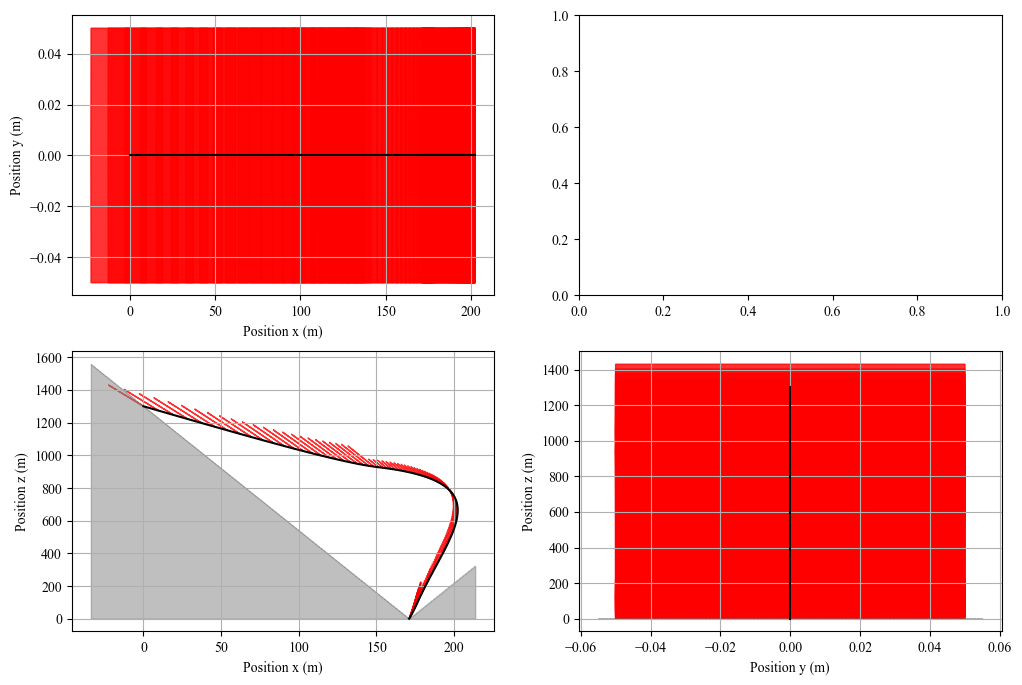

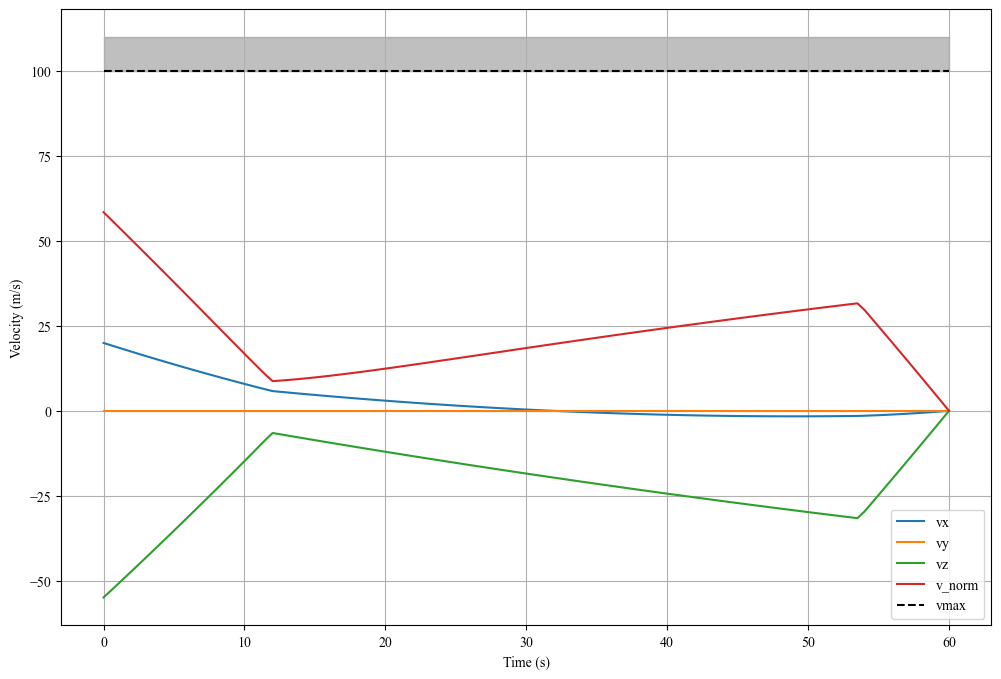

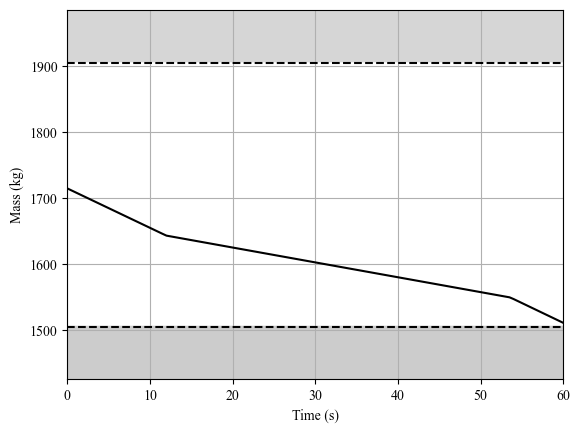

(120,)


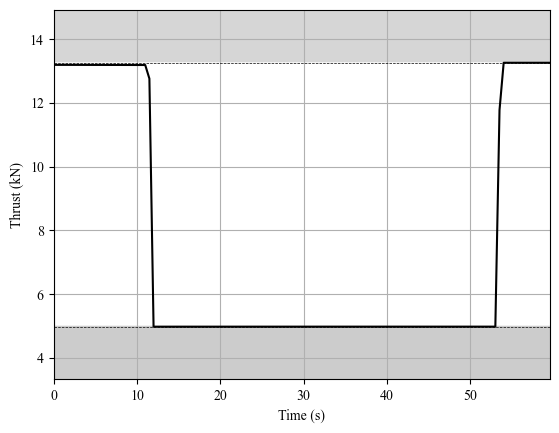

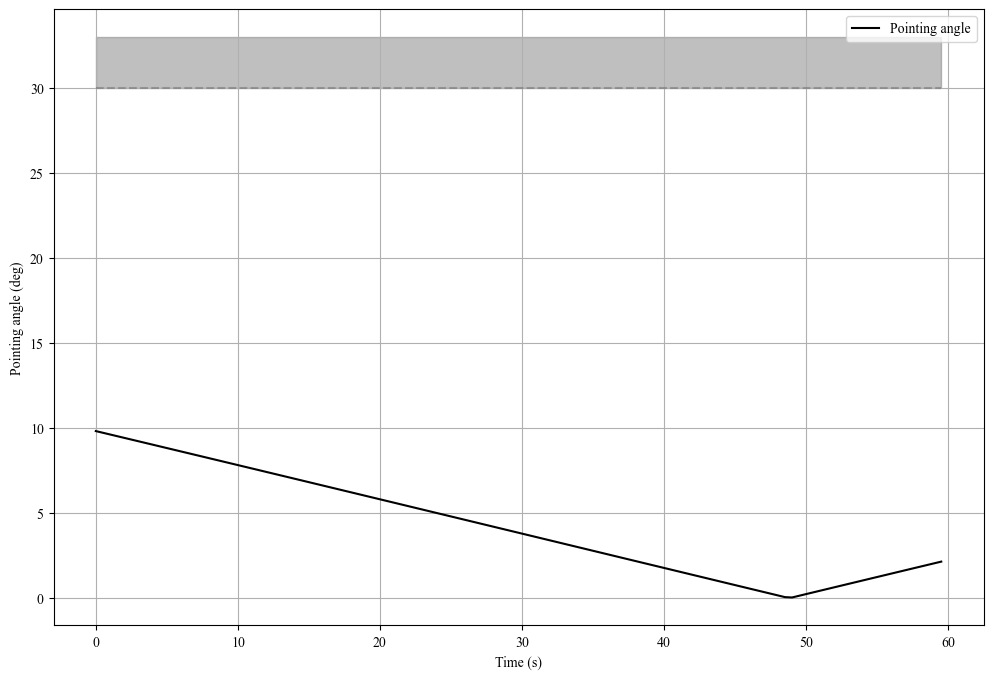

In [14]:

def solve_minfule(lander, x0, tf, N):
    # solve for initial guess; solve for soft landing with minimum fuel
    lcvx = lc.LCvxMinFuel(
            rocket=lander,
            N=N,
            parameterize_x0=False,
            parameterize_tf=False,
            fixed_target=False,
        )
    prob = lcvx.problem(x0=x0, tf=tf)
    prob.solve(solver=cp.ECOS, verbose=False)

    if prob.status != cp.OPTIMAL:
        raise RuntimeError(f"Solver failed to find optimal solution. Solver status: {prob.status}")

    sol = lc.get_vars(prob, ["X", "U"])
    r, v, z, u, sigma = lcvx.recover_variables(sol["X"], sol["U"])

    m = np.exp(z)
    X = np.hstack((r.T, v.T, m.reshape(-1, 1)))
    U = u.T * m[:-1].reshape(-1, 1)
    t = np.linspace(0, tf, N+1)

    return X, U, t


def get_init_guess(lander, x0_torch, tgo_torch, N):
    x0 = x0_torch.detach().numpy()
    tgo = tgo_torch.detach().numpy()
    X, U, _ = solve_minfule(lander, x0, tgo, N)
    X = torch.tensor(X, dtype=torch.float64)
    U = torch.tensor(U, dtype=torch.float64)
    return X, U

X, U, t = solve_minfule(lander, x0, tf, N)

plot_3sides(t[:-1], X, U, uskip=1, gsa=lander.gsa)

plot_vel(t, X, lander.vmax)

plot_mass(t, X, lander.mdry, lander.mwet)

plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)

plot_pointing(t[:-1], U, lander.pa)

In [15]:
for i in range(21):
    x = X[i, :]
    tgo = tf - t[i]
    point_5d = np.array([x[2], x[3], x[5], x[6], tgo])
    point_5d_ = 2 * (point_5d - lb) / (ub - lb) - 1
    print(f"alt: {x[2]:.2f}, vx: {x[3]:.2f}, vz: {x[5]:.2f}, mass: {x[6]:.2f}, tgo: {tgo:.2f}, inside hull: {inside_hull(point_5d_, hull_inner.equations)}")

alt: 1300.00, vx: 20.00, vz: -55.00, mass: 1714.50, tgo: 60.00, inside hull: True
alt: 1272.98, vx: 19.34, vz: -53.07, mass: 1711.51, tgo: 59.50, inside hull: True
alt: 1246.94, vx: 18.69, vz: -51.12, mass: 1708.53, tgo: 59.00, inside hull: True
alt: 1221.86, vx: 18.05, vz: -49.17, mass: 1705.54, tgo: 58.50, inside hull: True
alt: 1197.77, vx: 17.40, vz: -47.21, mass: 1702.55, tgo: 58.00, inside hull: True
alt: 1174.65, vx: 16.77, vz: -45.25, mass: 1699.57, tgo: 57.50, inside hull: True
alt: 1152.52, vx: 16.14, vz: -43.28, mass: 1696.58, tgo: 57.00, inside hull: True
alt: 1131.38, vx: 15.52, vz: -41.29, mass: 1693.59, tgo: 56.50, inside hull: True
alt: 1111.23, vx: 14.90, vz: -39.31, mass: 1690.61, tgo: 56.00, inside hull: True
alt: 1092.07, vx: 14.29, vz: -37.31, mass: 1687.62, tgo: 55.50, inside hull: True
alt: 1073.92, vx: 13.68, vz: -35.30, mass: 1684.64, tgo: 55.00, inside hull: True
alt: 1056.77, vx: 13.08, vz: -33.29, mass: 1681.65, tgo: 54.50, inside hull: True
alt: 1040.63, vx

In [16]:
alt: 1037.15, vx: 18.36, vz: -51.56, mass: 1697.40, tgo: 55.00, inside hull: True

SyntaxError: invalid syntax (3633417162.py, line 1)

In [17]:
sfmap, _ = nng.make_simple_sfmap(x_range=(-750, 750), y_range=(-750, 750), n_points=1000)

In [18]:
hidden_layers = [256, 256, 256]
model = lrn.NeuralReach(hidden_layers=hidden_layers)
model.load_state_dict(torch.load('../saved/controllable_set/reachset_train/20231115-025054/models_20231130-175526/mlp_reach/mlp_reach.pt'))
model.eval()

NeuralReach(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=4, bias=True)
    (10): Sigmoid()
  )
)

x: tensor([   0.0000,    0.0000, 1300.0000,   20.0000,    0.0000,  -55.0000,
           7.4469], dtype=torch.float64), tgo: 60.0, mean safety: 0.5129868002463557


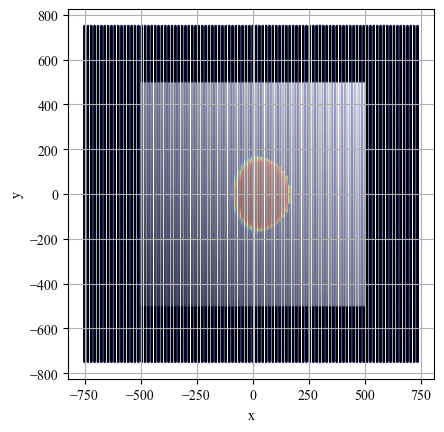

In [19]:
x0_torch = torch.from_numpy(x0).double()
#x0_torch = torch.from_numpy(np.array([-3.0000e-03, -4.8830e-09,  1.5000e+03, -3.0000e+01, -9.7659e-05, -5.5000e+01,  7.4953e+00])).double()
tgo = tf
mean_safety, reach_mask = nng.ic2mean_safety(x0_torch, tgo, model, sfmap, border_sharpness=10, fov=torch.tensor(lander.fov))
print(f'x: {x0_torch}, tgo: {tgo}, mean safety: {mean_safety}')
nng.visualize_nn_reachset(reach_mask, sfmap, nskip=10)

In [20]:

def visualize_results(u_, tgo_next, x0, dt, sfmap, model, rocket, border_sharpness, fov):

    # copy x0 tensor to avoid in-place operation
    x = x0.clone()
    for i in range(u_.shape[0]):
        u = nng.inverse_transform_u(u_[i], torch.tensor(rocket.rho1), torch.tensor(rocket.rho2), torch.tensor(rocket.pa))
        x = nng.dynamics(x, u, dt, torch.tensor(rocket.g), torch.tensor(rocket.alpha))

    mean_safety, reach_mask = nng.ic2mean_safety(x, tgo_next, model, sfmap, border_sharpness=border_sharpness, fov=fov)
    print(f'x: {x}, tgo: {tgo_next}, mean safety: {mean_safety}')
    
    nng.visualize_nn_reachset(reach_mask, sfmap, nskip=10)

# Initial guess inside feasible space must be provided.

1. Solve convex optimization for soft landing
2. Use solution from step 1 as an initial guess, solve for reachability-safe maximization at the next overservation
3. Go to step 1.

In [21]:
lander.alpha

0.00045320720576796816

alt: 1037.15, vx: 18.36, vz: -51.56, mass: 1697.40, tgo: 55.00, inside hull: True
Epoch 1/100, Current Objective Function Value = 21.77197062778022
Epoch 11/100, Current Objective Function Value = 21.88575629475909
Epoch 21/100, Current Objective Function Value = 21.951450917330277
Epoch 31/100, Current Objective Function Value = 21.996108431494356
Epoch 41/100, Current Objective Function Value = 22.080419468887136
Epoch 51/100, Current Objective Function Value = 22.193644779164067
Epoch 61/100, Current Objective Function Value = 22.39940933006751
Epoch 71/100, Current Objective Function Value = 22.60912422320341
Epoch 81/100, Current Objective Function Value = 22.768735738988404
Epoch 91/100, Current Objective Function Value = 23.244822440613376
x: tensor([ 9.3346e+01,  4.2491e-01,  1.0369e+03,  1.8490e+01,  1.1457e-01,
        -5.1645e+01,  7.4369e+00], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 55.0, mean safety: 0.5427911177904315


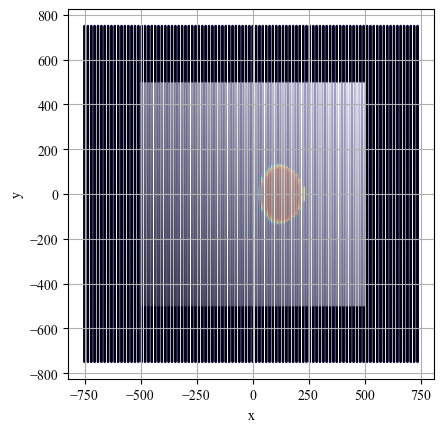

alt: 791.90, vx: 16.84, vz: -48.00, mass: 1680.39, tgo: 50.00, inside hull: True
Epoch 1/100, Current Objective Function Value = 23.7721592802313
Epoch 11/100, Current Objective Function Value = 24.243991208446147
Epoch 21/100, Current Objective Function Value = 24.329166385721347
Epoch 31/100, Current Objective Function Value = 24.44928541870502
Epoch 41/100, Current Objective Function Value = 24.587736090090406
Epoch 51/100, Current Objective Function Value = 24.99428960321545
Epoch 61/100, Current Objective Function Value = 25.43630596193864
Epoch 71/100, Current Objective Function Value = 25.901280753487864
Epoch 81/100, Current Objective Function Value = 26.826691862512806
Epoch 91/100, Current Objective Function Value = 27.780894983486803
x: tensor([ 1.9271e+02,  1.0015e+00,  7.9165e+02,  2.0360e+01,  1.2636e-01,
        -4.8037e+01,  7.4268e+00], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 50.0, mean safety: 0.5784776049741986


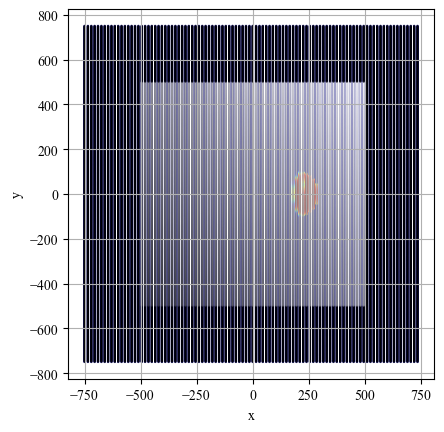

alt: 566.02, vx: 18.35, vz: -44.20, mass: 1663.31, tgo: 45.00, inside hull: True
Epoch 1/100, Current Objective Function Value = 26.857828026640814
Epoch 11/100, Current Objective Function Value = 27.83608027468377
Epoch 21/100, Current Objective Function Value = 27.959083645182808
Epoch 31/100, Current Objective Function Value = 28.14506672376246
Epoch 41/100, Current Objective Function Value = 28.412018667767065
Epoch 51/100, Current Objective Function Value = 28.60831829891074
Epoch 61/100, Current Objective Function Value = 28.89075853048188
Epoch 71/100, Current Objective Function Value = 29.294792764200466
Epoch 81/100, Current Objective Function Value = 29.055365125981286
Epoch 91/100, Current Objective Function Value = 29.298050480135906
x: tensor([ 3.0331e+02,  1.6394e+00,  5.6582e+02,  2.2765e+01,  1.4447e-01,
        -4.4185e+01,  7.4166e+00], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 45.0, mean safety: 0.6165775025051303


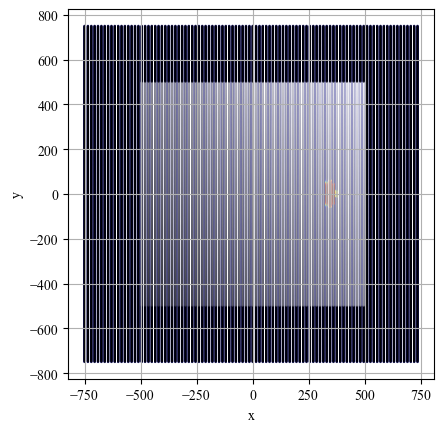

alt: 360.98, vx: 20.25, vz: -40.16, mass: 1646.11, tgo: 40.00, inside hull: True
Epoch 1/100, Current Objective Function Value = 31.5017233476568
Epoch 11/100, Current Objective Function Value = inf
Epoch 21/100, Current Objective Function Value = inf
Epoch 31/100, Current Objective Function Value = inf
Epoch 41/100, Current Objective Function Value = inf
Epoch 51/100, Current Objective Function Value = inf
Epoch 61/100, Current Objective Function Value = inf
Epoch 71/100, Current Objective Function Value = inf
Epoch 81/100, Current Objective Function Value = inf
Epoch 91/100, Current Objective Function Value = inf
x: tensor([ 4.2855e+02,  2.3686e+00,  3.6104e+02,  2.5587e+01,  1.5984e-01,
        -4.0041e+01,  7.4061e+00], dtype=torch.float64, grad_fn=<CopySlices>), tgo: 40.0, mean safety: 1.1548021712514026e-11


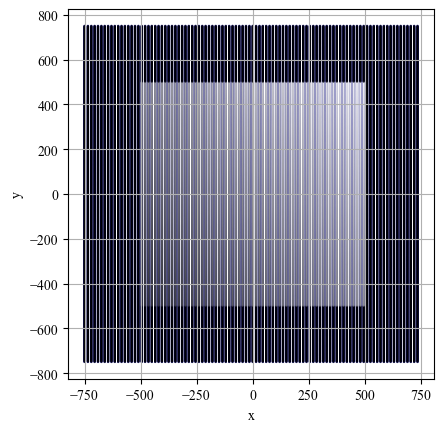

RuntimeError: Solver failed to find optimal solution. Solver status: infeasible

In [22]:
from torch.autograd import Variable

x0_torch = torch.from_numpy(x0).double()

n_horizon = 10

lb_torch = torch.from_numpy(lb).double()
ub_torch = torch.from_numpy(ub).double()

sfmap = sfmap.clone().requires_grad_(True)
x0_torch = x0_torch.clone().detach().requires_grad_(True)
tgo_torch = torch.tensor(tgo, requires_grad=True)

x_hist = []
u_hist = []
i = 0
while x0_torch[2] > 250.0:
    _, u0 = get_init_guess(lander, x0_torch, tgo_torch, n_horizon)
    u_ = torch.zeros((n_horizon, 3), dtype=torch.float64)
    for j in range(n_horizon):
        u_[j, :] = nng.transform_u(u0[j, :], torch.tensor(lander.rho1), torch.tensor(lander.rho2), torch.tensor(lander.pa))

    u_.requires_grad_(True)

    # evaluate initial guess is feasible or not
    x_next = nng.u_2x(u_, x0_torch, dt, lander)

    # compute log barrier
    r, v, z = x_next[:3], x_next[3:6], x_next[6]
    mass = torch.exp(z)
    alt = r[2]
    vx = torch.norm(v[:2])
    vz = v[2]
    tgo_next = tgo_torch - n_horizon * dt
    x_next = torch.tensor([alt, vx, vz, mass, tgo_next])
    x_next_ = 2 * (x_next - lb_torch) / (ub_torch - lb_torch) - 1

    point_5d_ = x_next_.detach().numpy()
    print(f"alt: {alt:.2f}, vx: {vx:.2f}, vz: {vz:.2f}, mass: {mass:.2f}, tgo: {tgo_next:.2f}, inside hull: {inside_hull(point_5d_, hull_inner.equations)}")

    #"""
    eqs = torch.tensor(hull_inner.equations)

    coeffs = eqs[:, :-1]
    intercepts = eqs[:, -1]

    dot_products = torch.matmul(coeffs, x_next_) + intercepts
    # assert all dot products are negative
    assert torch.all(dot_products < 0)

    # Make objective function
    def f(u_):
        # define decision variables
        u_ = u_.reshape(n_horizon, 3)

        # compute next state and mean safety
        mean_safety, _, x_next = nng.u_2mean_safety(
            u_=u_,
            tgo_next=tgo_next,
            x0=x0_torch,
            dt=dt,
            rocket=lander,
            sfmap=sfmap,
            model=model,
            fov=torch.tensor(lander.fov),
            border_sharpness=10
        )

        #"""
        # compute log barrier
        r, v, z = x_next[:3], x_next[3:6], x_next[6]
        mass = torch.exp(z)
        alt = r[2]
        vx = torch.norm(v[:2])
        vz = v[2]
        x_next = torch.tensor([alt, vx, vz, mass, tgo_next])
        x_next_ = 2 * (x_next - lb_torch) / (ub_torch - lb_torch) - 1

        log_barrier = torch.tensor(0.0)

        #"""
        eqs = torch.tensor(hull_inner.equations)

        coeffs = eqs[:, :-1]
        intercepts = eqs[:, -1]

        ctrlablity_cstr = torch.matmul(coeffs, x_next_) + intercepts  # must be <= 0

        # clamp controllability constraints to be negative
        ctrlablity_cstr = torch.clamp(ctrlablity_cstr, max=0.0)

        log_barrier = -torch.sum(torch.log(-ctrlablity_cstr))
       
        eps = 1e-4
        return -mean_safety + eps * log_barrier
        

    u_ = u_.reshape(-1)
    #u_opt = nng.basinhopping_torch(f, u_, bounds=[(0., 1.)], niter=10, verbose=True)
    u_opt = nng.adam_optimization(f, u_, bounds=[0., 1.], lr=0.01, num_epochs=100, tol=np.inf, verbose=True)
    u_opt = u_opt.reshape(n_horizon, 3)
    visualize_results(u_opt, tgo_next, x0_torch, dt, sfmap, model, lander, border_sharpness=10, fov=torch.tensor(lander.fov))

    x0_torch = nng.u_2x(u_opt, x0_torch, dt, lander).clone().detach().requires_grad_(True)

    x_hist.append(x0_torch.detach().numpy())
    u_hist.append(u_opt.detach().numpy())
    tgo_torch = tgo_next.clone().detach().requires_grad_(True)
    i += 1

In [17]:
dt

0.5

log barrier: 3311.719482421875
dot products: tensor([-0.5556, -0.6194, -0.9175,  ..., -0.4445, -0.4678, -0.4445],
       dtype=torch.float64), closest: -0.0018619310962649516, log-max: 6.2861411060402475


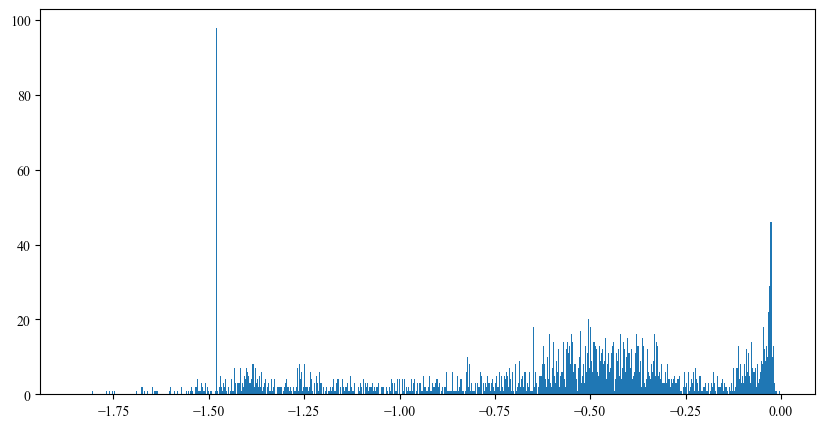

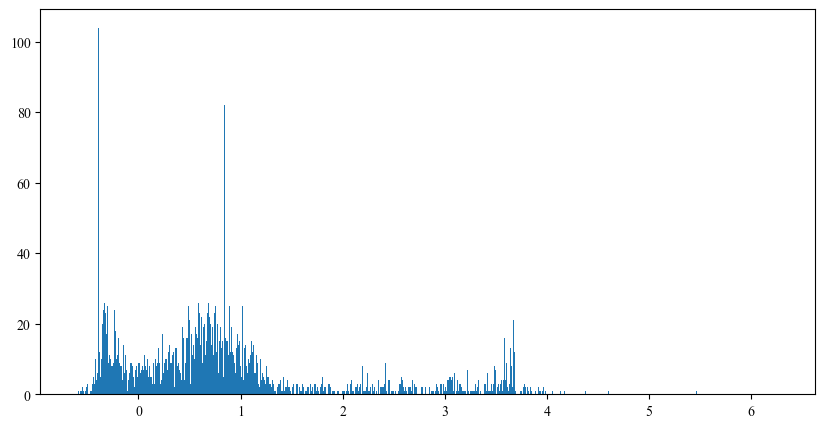

log barrier: 0.8883365858415224


In [17]:
alt, vx, vz, mass = x0_torch[2], x0_torch[3], x0_torch[5], torch.exp(x0_torch[6])
x = np.array([alt, vx, vz, mass, tgo])
x_ = 2 * (x - lb) / (ub - lb) - 1
x_torch_ = torch.from_numpy(x_).double()
log_barrier = torch.tensor(0.0)

for eq in hull_inner.equations:
    # Convert eq to a PyTorch tensor if it's not already
    eq_tensor = torch.tensor(eq)

    # Perform the dot product using torch.dot or torch.matmul
    # torch.dot works for 1D tensors, torch.matmul can handle 2D
    dot_product = torch.dot(eq_tensor[:-1], x_torch_)

    # Subtract the logarithm of the dot product plus the last element of eq_tensor
    log_barrier -= torch.log(-(dot_product + eq_tensor[-1]))

print(f'log barrier: {log_barrier}')


eqs = torch.tensor(hull_inner.equations)

coeffs = eqs[:, :-1]
intercepts = eqs[:, -1]

dot_products = torch.matmul(coeffs, x_torch_) + intercepts
print(f'dot products: {dot_products}, closest: {torch.max(dot_products)}, log-max: {-torch.log(-torch.max(dot_products))}')

# plot histogram of dot products
plt.figure(figsize=(10, 5))
plt.hist(dot_products.detach().numpy(), bins=1000)
plt.show()

# plot histogram of log of dot products
plt.figure(figsize=(10, 5))
plt.hist(-torch.log(-dot_products).detach().numpy(), bins=1000)
plt.show()

log_barrier = -torch.mean(torch.log(-dot_products))

print(f'log barrier: {log_barrier}')